In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, confusion_matrix, ConfusionMatrixDisplay

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/anasofia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anasofia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

importando os dados

In [2]:
data = pd.read_csv('data.csv')
data.fillna('', inplace=True)
data.head()

,contest,problem_name,problem_statement,problem_tags
0,325,A,You are given n rectangles. The corners of rec...,"implementation,*1500"
1,325,B,Daniel is organizing a football tournament. He...,"binarysearch,math,*1800"
2,325,C,Piegirl has found a monster and a book about m...,"dfsandsimilar,graphs,shortestpaths,*2600"
3,325,D,"In a far away land, there exists a planet shap...","dsu,*2900"
4,325,E,Piegirl found the red button. You have one las...,"combinatorics,dfsandsimilar,dsu,graphs,greedy,..."


pre-processando

In [3]:
sw = stopwords.words('english')
sw += ['input', 'output', 'th', 'print', 'test', 'case', 'line']
lemma = WordNetLemmatizer()
text = data.problem_statement

# Problem_statement
print(text[8341][:100])
print('------------')
text = text.apply(lambda x: re.sub(r'\${1,3}(.*?)\${1,3}', ' ',x))
text = text.apply(lambda x: re.sub(r'(?:\\)[a-zA-Z]+', ' ',x))
text = text.apply(lambda x: re.sub(r'\{(.*?)\}', ' ',x))
text = text.apply(lambda x: re.sub(r"[\,|\.|\(|\)|\!|\?|\:|\']",' ',x)) # removendo caracteres especiais
text = text.apply(lambda x: [i for i in x.split() if i.lower() not in sw]) # removendo stop-words
text = text.apply(lambda x: ' '.join([lemma.lemmatize(i) for i in x])) # lemmatizando todo

# Topics
topics = data.problem_tags
topics = topics.apply(lambda x: re.sub('[*][0-9]+','',x)) # remove os ratings *800 etc
topics = topics.apply(lambda x: [i for i in x.split(',') if i != '']) # tira strings vazias

print(text[8341][:100])
print(topics[0])


At first, let's define function $$$f(x)$$$ as follows: $$$$$$ \begin{matrix} f(x) & = & \left\{ \beg
------------
first let define function follows f x & = & \ & x \\ x - 1 & see choose value apply function apply e
['implementation']


coletando topicos

In [4]:
lista = topics.to_list()

d = dict()
for x in lista:
    for y in x:
        if y not in d:
            d[y] = 1
        else:   
            d[y] += 1

labelfreq = sorted(d.items(), key=lambda item:item[1], reverse=True)

for i in labelfreq:
    print(i)

('implementation', 2221)
('math', 2028)
('greedy', 1950)
('dp', 1673)
('datastructures', 1290)
('constructivealgorithms', 1181)
('bruteforce', 1173)
('graphs', 901)
('binarysearch', 786)
('sortings', 759)
('dfsandsimilar', 718)
('trees', 617)
('strings', 572)
('numbertheory', 554)
('combinatorics', 461)
('*specialproblem', 436)
('twopointers', 361)
('bitmasks', 349)
('geometry', 343)
('dsu', 247)
('shortestpaths', 220)
('probabilities', 196)
('divideandconquer', 189)
('games', 161)
('hashing', 160)
('interactive', 145)
('flows', 109)
('matrices', 104)
('stringsuffixstructures', 75)
('graphmatchings', 65)
('fft', 61)
('ternarysearch', 52)
('meet-in-the-middle', 36)
('expressionparsing', 35)
('2-sat', 25)
('chineseremaindertheorem', 13)
('schedules', 7)


vetorizando e fazendo 

In [5]:
# parametros

ngram_range = (1,3)
max_df = 0.9
min_df = 4

norm = 'l2'
smooth_idf = True

In [6]:
vec = CountVectorizer(ngram_range=ngram_range,
                      max_df=max_df,
                      min_df=min_df)

tfidf = TfidfTransformer(norm=norm,
                         smooth_idf=smooth_idf)

X = vec.fit_transform(text)
X_tfidf = tfidf.fit(X)


mapeando as labels e criando matrix de indicacao

In [7]:
aux = {}
for i, j in enumerate(labelfreq):
    aux[j[0]] = i
aux

{'implementation': 0,
 'math': 1,
 'greedy': 2,
 'dp': 3,
 'datastructures': 4,
 'constructivealgorithms': 5,
 'bruteforce': 6,
 'graphs': 7,
 'binarysearch': 8,
 'sortings': 9,
 'dfsandsimilar': 10,
 'trees': 11,
 'strings': 12,
 'numbertheory': 13,
 'combinatorics': 14,
 '*specialproblem': 15,
 'twopointers': 16,
 'bitmasks': 17,
 'geometry': 18,
 'dsu': 19,
 'shortestpaths': 20,
 'probabilities': 21,
 'divideandconquer': 22,
 'games': 23,
 'hashing': 24,
 'interactive': 25,
 'flows': 26,
 'matrices': 27,
 'stringsuffixstructures': 28,
 'graphmatchings': 29,
 'fft': 30,
 'ternarysearch': 31,
 'meet-in-the-middle': 32,
 'expressionparsing': 33,
 '2-sat': 34,
 'chineseremaindertheorem': 35,
 'schedules': 36}

In [53]:
def get_matrix(n_labels, topics):
    n_docs = len(topics)

    labels = [i[0] for i in labelfreq][:n_labels-1]
    labels.append('outros')

    ind_matrix = np.zeros(shape=(n_docs, n_labels),
                          dtype=np.int8)
    
    for i in range(n_docs):
        achou = False
        for j in topics[i]:
            if j in labels:
                ind_matrix[i][aux[j]] = 1
                achou = True
        if not achou:
            ind_matrix[i][-1] = 1

    return ind_matrix, labels

treinando a svm

[]()

In [81]:
# parametros

n_labels = 37

In [82]:
Y, labels = get_matrix(n_labels, topics)

In [83]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# todo cross validation

In [84]:
# todo configurar parametros

model = OneVsRestClassifier(LinearSVC())
model.fit(X_train, Y_train)

/home/anasofia/Documents/UnB/PIBIC/classificador-cf/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/anasofia/Documents/UnB/PIBIC/classificador-cf/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/anasofia/Documents/UnB/PIBIC/classificador-cf/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/anasofia/Documents/UnB/PIBIC/classificador-cf/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/anasofia/Documents/UnB/PIBIC/classificador-cf/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

OneVsRestClassifier(estimator=LinearSVC())

validando

In [85]:
predict = model.predict(X_test)

In [86]:
scores = classification_report(Y_test, predict, target_names=labels, output_dict=True)
print(scores)

/home/anasofia/Documents/UnB/PIBIC/classificador-cf/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'implementation': {'precision': 0.451505016722408, 'recall': 0.4251968503937008, 'f1-score': 0.43795620437956206, 'support': 635}, 'math': {'precision': 0.5476190476190477, 'recall': 0.5244299674267101, 'f1-score': 0.5357737104825291, 'support': 614}, 'greedy': {'precision': 0.5095419847328244, 'recall': 0.44798657718120805, 'f1-score': 0.4767857142857143, 'support': 596}, 'dp': {'precision': 0.48314606741573035, 'recall': 0.4387755102040816, 'f1-score': 0.4598930481283422, 'support': 490}, 'datastructures': {'precision': 0.5411764705882353, 'recall': 0.5054945054945055, 'f1-score': 0.5227272727272727, 'support': 364}, 'constructivealgorithms': {'precision': 0.48732394366197185, 'recall': 0.4942857142857143, 'f1-score': 0.4907801418439717, 'support': 350}, 'bruteforce': {'precision': 0.24295774647887325, 'recall': 0.20474777448071216, 'f1-score': 0.22222222222222224, 'support': 337}, 'graphs': {'precision': 0.6633165829145728, 'recall': 0.5258964143426295, 'f1-score': 0.58666666666666

/home/anasofia/Documents/UnB/PIBIC/classificador-cf/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
def plot(scores, labels):
    """Plot scores of best models in a barplot based on f1 score"""
    
    n_labels = len(labels)

    aux = pd.DataFrame(index=[labels] ,columns=['precision', 'recall', 'f1-score'], dtype=float)
    
    for j, i in enumerate(scores):
        if j == n_labels: break
        scores[i].pop('support', None)
        aux.iloc[j] = scores[i]
    
    # aux.set_index(labels, inplace=True)
    print(aux)

    aux.sort_values('f1-score', ascending=False).plot(
        kind='bar',
        figsize=(12,5),
        title='Score of Highest Performing Models',
        ylabel='score',
        colormap='plasma'
    )
    plt.ylim(bottom=0)
    plt.show()

                         precision    recall  f1-score
implementation            0.451505  0.425197  0.437956
math                      0.547619  0.524430  0.535774
greedy                    0.509542  0.447987  0.476786
dp                        0.483146  0.438776  0.459893
datastructures            0.541176  0.505495  0.522727
constructivealgorithms    0.487324  0.494286  0.490780
bruteforce                0.242958  0.204748  0.222222
graphs                    0.663317  0.525896  0.586667
binarysearch              0.345912  0.229167  0.275689
sortings                  0.327160  0.273196  0.297753
dfsandsimilar             0.459627  0.300813  0.363636
trees                     0.662500  0.566845  0.610951
strings                   0.647887  0.544379  0.591640
numbertheory              0.520325  0.395062  0.449123
combinatorics             0.500000  0.262411  0.344186
*specialproblem           0.476190  0.441176  0.458015
twopointers               0.260870  0.122449  0.166667
bitmasks  

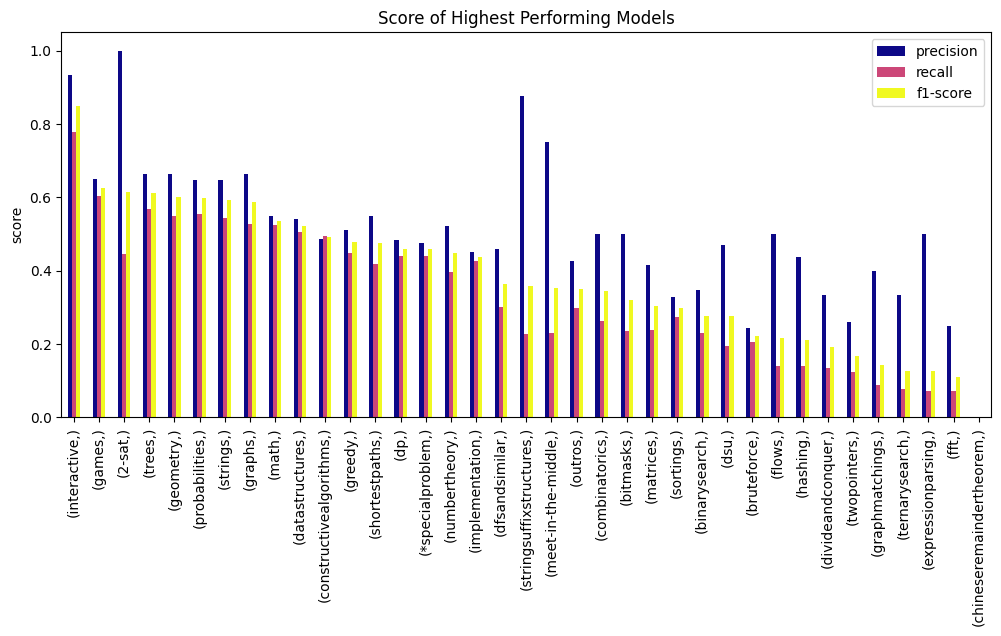

In [90]:
plot(scores, labels)